In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed
import os, shutil
import datetime 
import holidays
import dateutil.easter as easter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import StratifiedGroupKFold

from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance

from xgboost import plot_importance
from matplotlib import pyplot
import missingno as msno
import plotly.express as px

import optuna

# Keras
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline


# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from tensorflow.keras.layers import LSTM, Flatten, TimeDistributed, Conv1D, Input, Dense, Multiply, Add, Activation, GRU, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model, save_model, Sequential
from tensorflow.data import Dataset
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,MaxPooling1D,BatchNormalization, Lambda, AveragePooling1D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras as keras

In [3]:
train_df = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
original_train_df = train_df.copy()
test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


# EDA

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [5]:
train_df.describe()

,row_id,num_sold
count,70128.000000,70128.000000
mean,35063.500000,194.296986
std,20244.354176,126.893874
min,0.000000,19.000000
25%,17531.750000,95.000000
50%,35063.500000,148.000000
75%,52595.250000,283.000000
max,70127.000000,986.000000


In [6]:
train_df.isna().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [7]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [8]:
day=pd.DatetimeIndex(train_df['date']).day
month=train_df['date'].dt.month_name()
year=pd.DatetimeIndex(train_df['date']).year
weekday=train_df['date'].dt.day_name()
quater= train_df['date'].dt.quarter

day1=pd.DatetimeIndex(test_df['date']).day
month1=test_df['date'].dt.month_name()
year1=pd.DatetimeIndex(test_df['date']).year
weekday1=test_df['date'].dt.day_name()
quater1= test_df['date'].dt.quarter

quater= train_df['date'].dt.quarter


In [9]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [10]:
train_df.insert(loc=2, column='day', value=day)
train_df.insert(loc=3,column='weekday',value=weekday)
train_df.insert(loc=4, column='month', value=month)
train_df.insert(loc=5, column='quater', value=quater)
train_df.insert(loc=6, column='year', value=year)

In [11]:
test_df.insert(loc=2, column='day', value=day1)
test_df.insert(loc=3,column='weekday',value=weekday1)
test_df.insert(loc=4, column='month', value=month1)
test_df.insert(loc=5, column='quater', value=quater1)
test_df.insert(loc=6, column='year', value=year1)


In [12]:
train_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,num_sold
0,0,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240


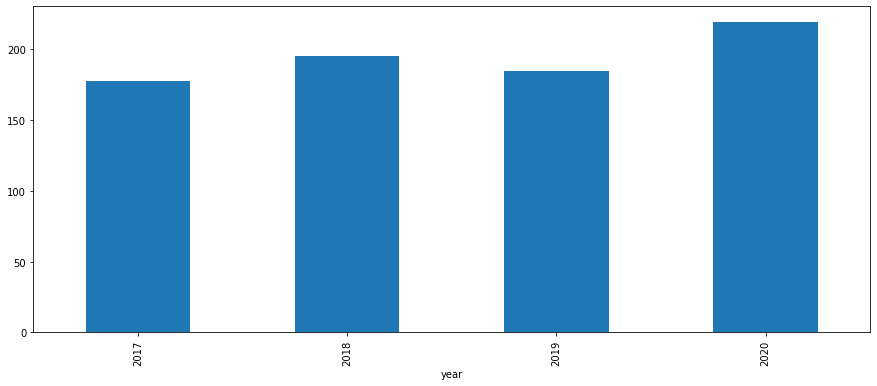

In [13]:
plt.figure(figsize=(15,6))
train_df.groupby('year')['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

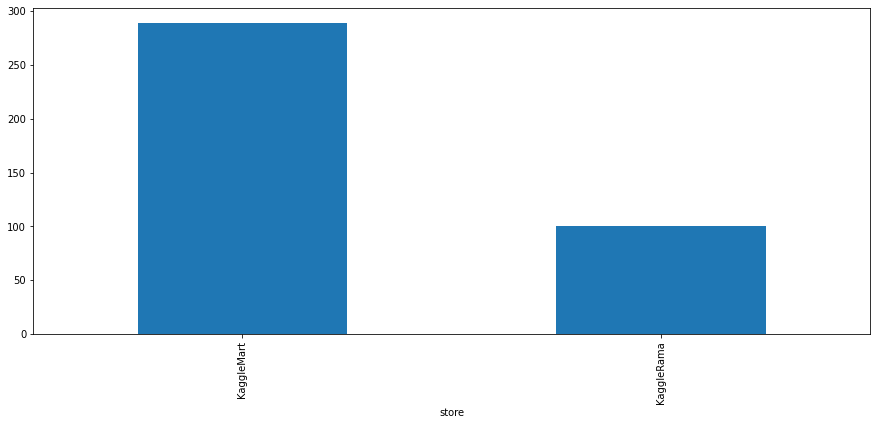

In [14]:
plt.figure(figsize=(15,6))
train_df.groupby('store')['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

Text(0.5, 1.0, 'Number sold in each store')

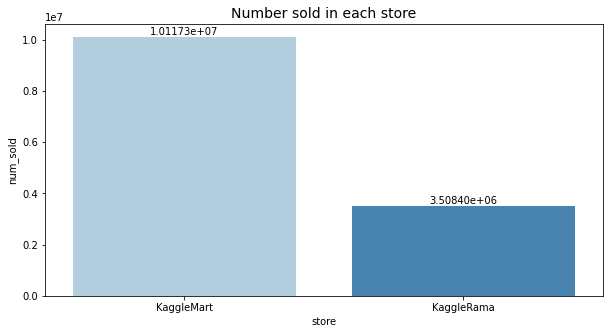

In [15]:
sld_store = train_df.groupby(['store']).sum().reset_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="store", y='num_sold', data=sld_store, palette="Blues")
ax.bar_label(ax.containers[0])
ax.set_title('Number sold in each store',
             fontsize = 14)

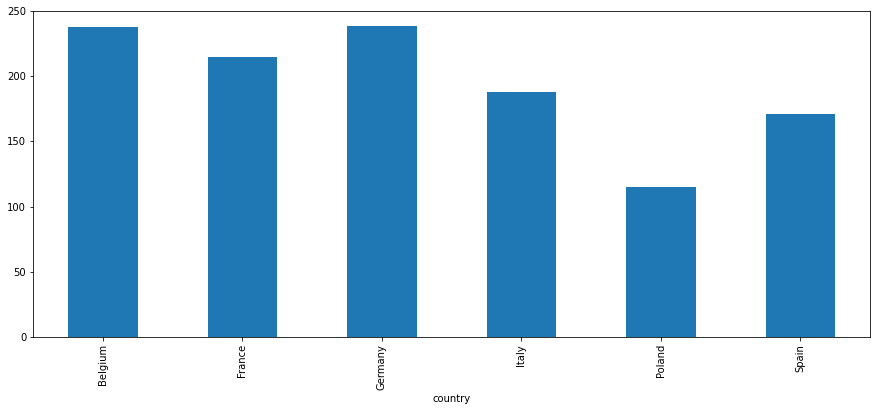

In [16]:
plt.figure(figsize=(15,6))
train_df.groupby('country')['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

Text(0.5, 1.0, 'Number sold of each product')

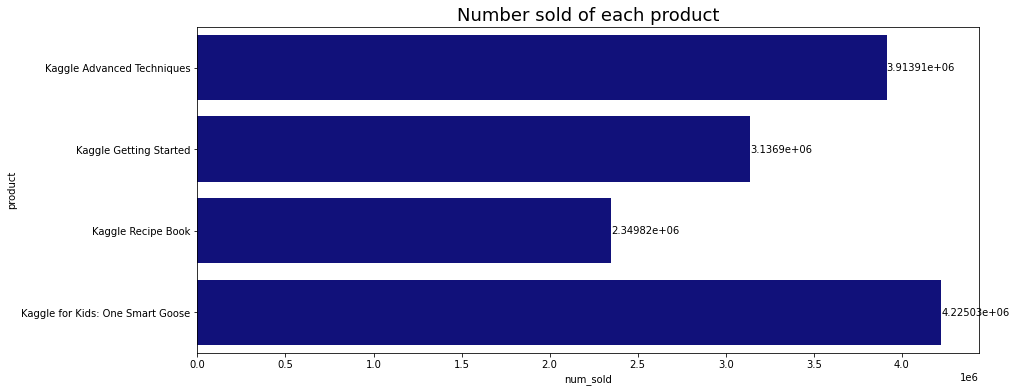

In [17]:
sld_item= train_df.groupby(['product']).sum().reset_index()
plt.figure(figsize=(14,6))
ax = sns.barplot(x="num_sold", y='product', data=sld_item,color="darkblue")
ax.bar_label(ax.containers[0])
ax.set_title('Number sold of each product', fontsize = 18) 

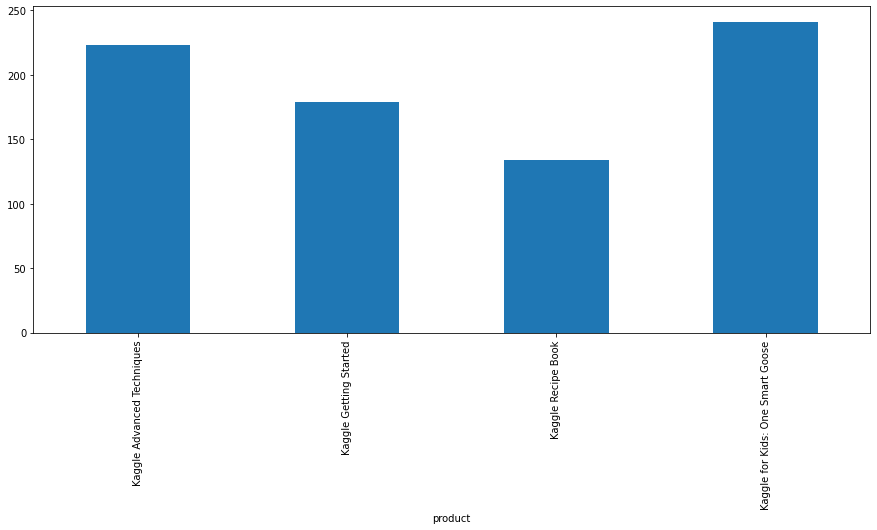

In [18]:
plt.figure(figsize=(15,6))
train_df.groupby('product')['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

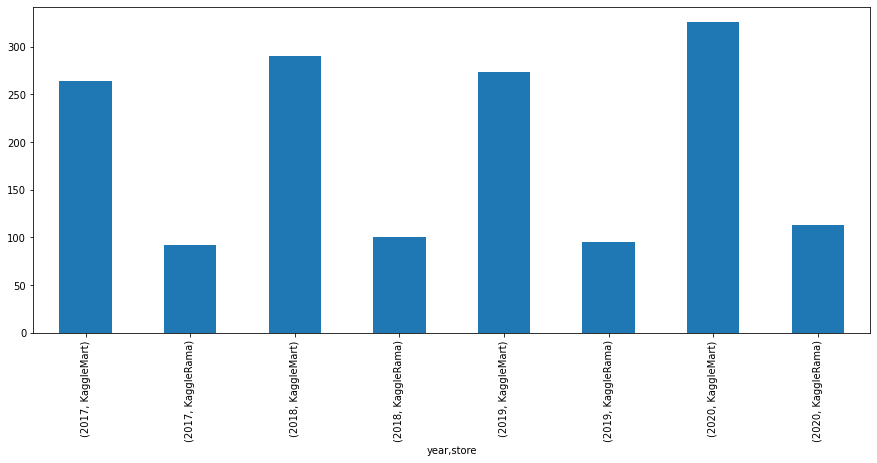

In [19]:
plt.figure(figsize=(15,6))
train_df.groupby(['year','store'])['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

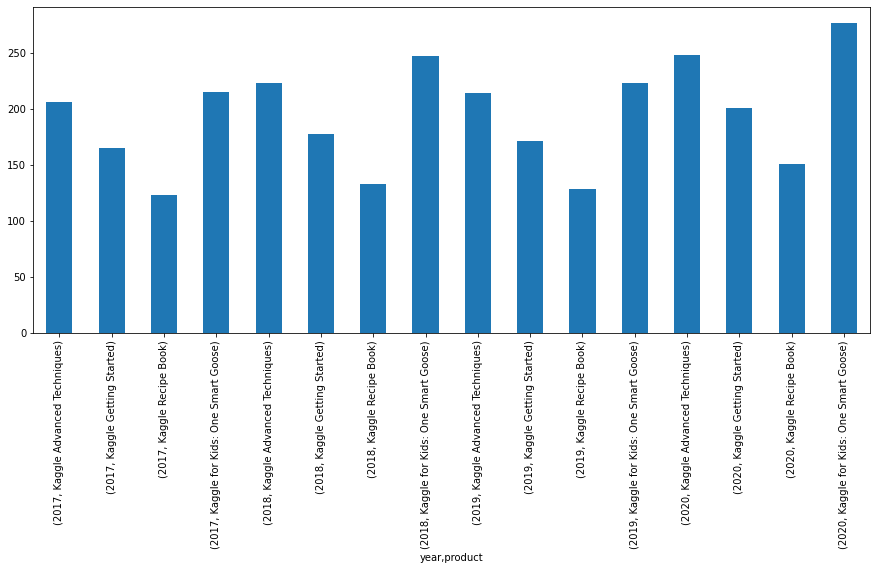

In [20]:
plt.figure(figsize=(15,6))
train_df.groupby(['year','product'])['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

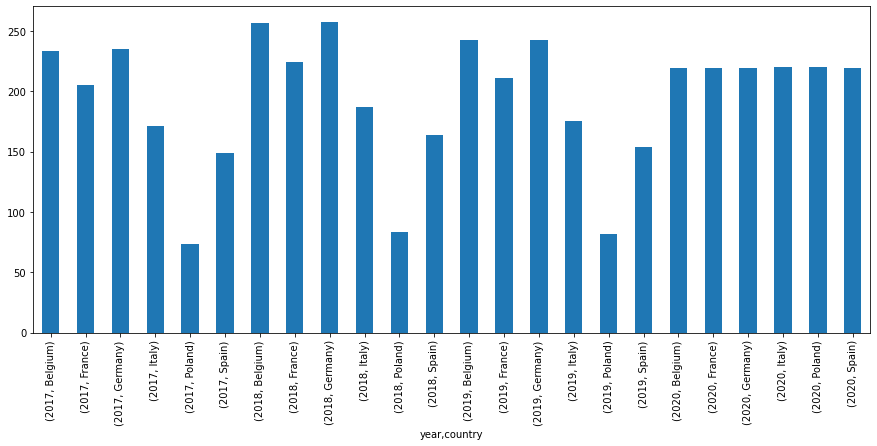

In [21]:
plt.figure(figsize=(15,6))
train_df.groupby(['year','country'])['num_sold'].mean().plot(kind='bar',stacked=True)
plt.show()

<Figure size 1080x4320 with 0 Axes>

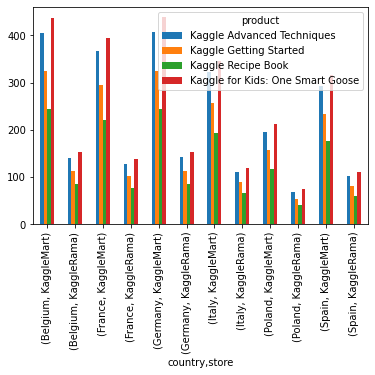

In [22]:
plt.figure(figsize=(15,60))
train_df.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=False)
plt.show()

<Figure size 1440x36000 with 0 Axes>

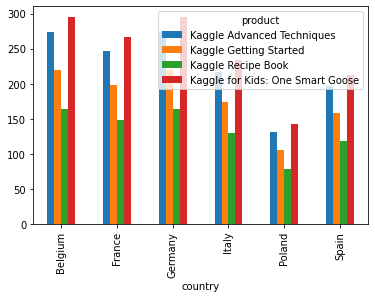

In [23]:
plt.figure(figsize=(20,500))
train_df.groupby(['country','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=False)
plt.show()

<Figure size 1440x360 with 0 Axes>

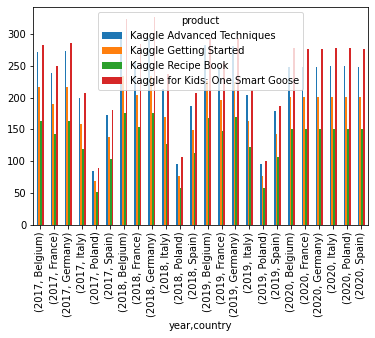

In [24]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
train_df.groupby(['year','country','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=False)
plt.show()

<Figure size 1440x360 with 0 Axes>

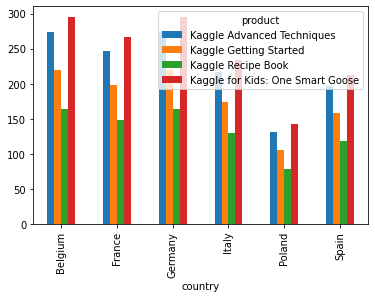

In [25]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
train_df.groupby(['country','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=False)
plt.show()

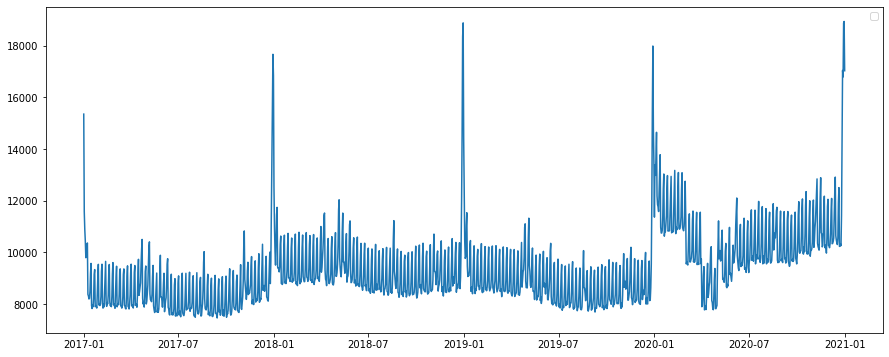

In [26]:
plt.figure(figsize=(15,6))
train_gp = train_df.groupby('date').sum().reset_index()
plt.plot(train_gp['date'], train_gp['num_sold'])
plt.legend()
plt.show()

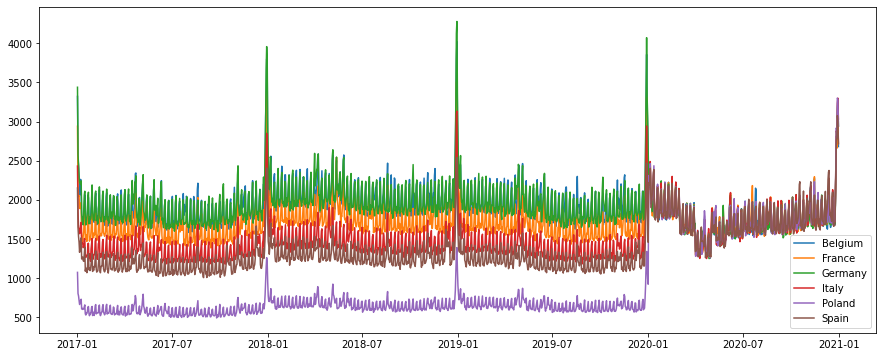

In [27]:
plt.figure(figsize=(15,6))
for country in train_df['country'].unique():
    filt_train = train_df[train_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

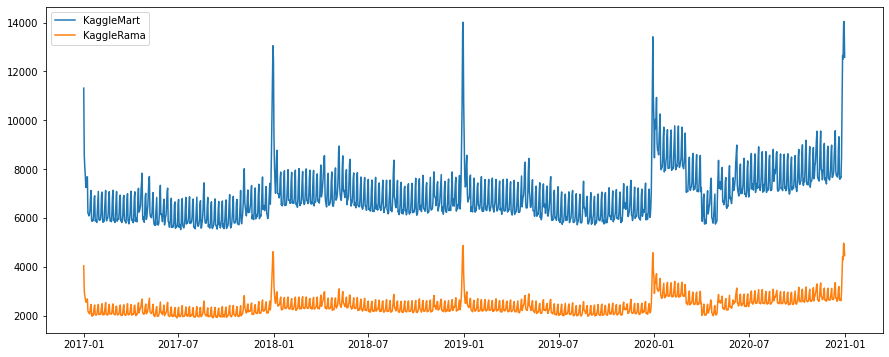

In [28]:
plt.figure(figsize=(15,6))
for country in train_df['store'].unique():
    filt_train = train_df[train_df['store'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

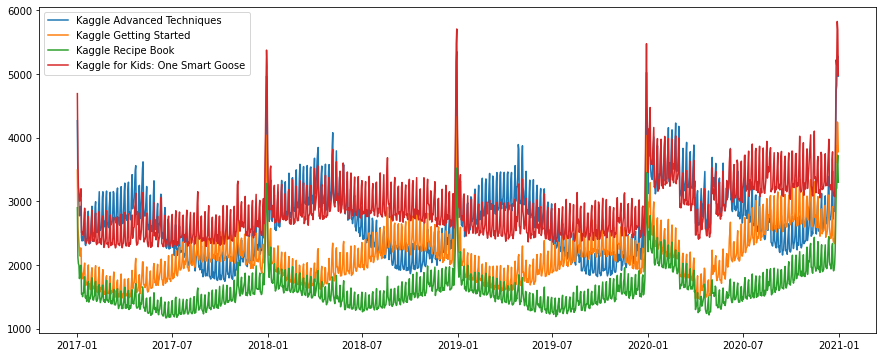

In [29]:
plt.figure(figsize=(15,6))
for country in train_df['product'].unique():
    filt_train = train_df[train_df['product'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

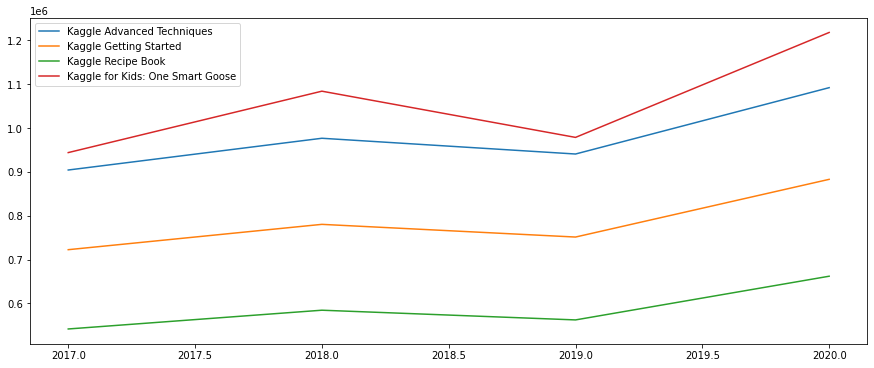

In [30]:
plt.figure(figsize=(15,6))
for country in train_df['product'].unique():
    filt_train = train_df[train_df['product'] == country]

    train_gp = filt_train.groupby('year').sum().reset_index()
    plt.plot(train_gp['year'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

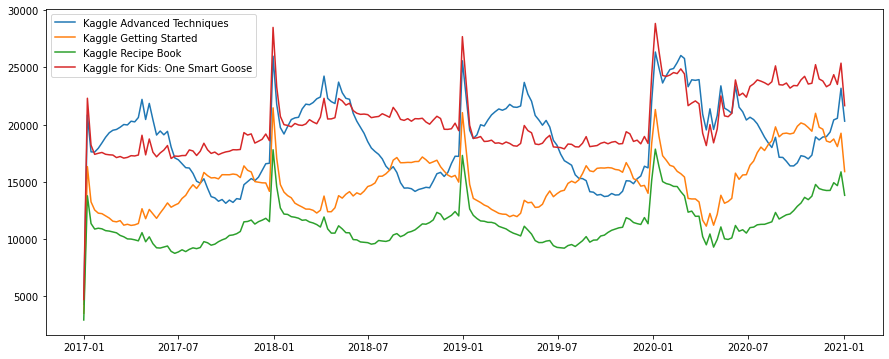

In [31]:
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = weekly_df[weekly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

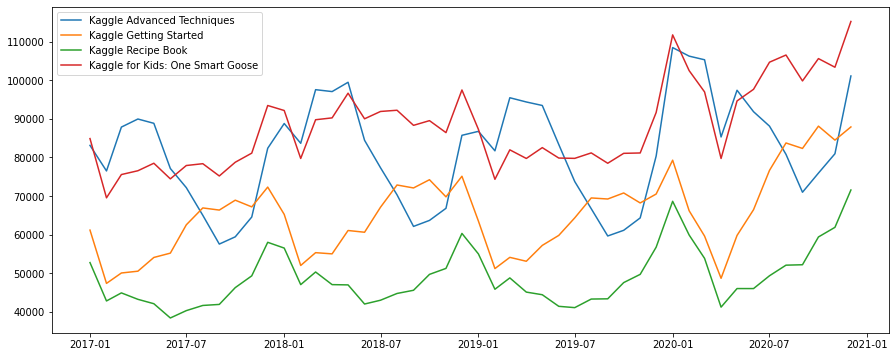

In [32]:
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = monthly_df[monthly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [33]:
plt2= train_df.groupby(['country','month'])['num_sold'].sum().reset_index()
#plt2.reset_index(inplace=True)   
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
plt2['time'] = pd.Categorical(plt2['month'], categories=months, ordered=True)
plt2 = plt2.sort_values(['time','num_sold'], ascending= [True,False])
fig = px.line(plt2, x="time", y="num_sold", title= "Number sold products by month in each country",color="country", markers=True)
fig.show()

In [34]:
plt2= train_df.groupby(['country','year'])['num_sold'].sum().reset_index()
#plt2.reset_index(inplace=True)   
years = [2017, 2018, 2019, 2020]
plt2['time'] = pd.Categorical(plt2['year'],categories=years, ordered=True)
plt2 = plt2.sort_values(['time','num_sold'], ascending= [True,False])
fig = px.line(plt2, x="time", y="num_sold", title= "Number sold products by month in each country",color="country", markers=True)
fig.show()

In [35]:
plt4= train_df.groupby(['country','weekday'])['num_sold'].sum().reset_index().set_index('weekday')
plt4['Day_id'] = plt4.index
# plt4['Day_id'] = plt4['Day_id'].map(sorterIndex)
plt4.sort_values('Day_id', inplace=True)
fig = px.line(plt4, x=plt4.index, y="num_sold", title= "Total daily sold products in each country",color="country", markers=True)
fig.show()

In [36]:
### plotdata preparation
sld_year = train_df.groupby(['year']).mean().reset_index()
sld_month = train_df.groupby(['month']).mean().reset_index().set_index('month')
sld_day = train_df.groupby(['weekday']).mean().reset_index().set_index('weekday')
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sld_month= sld_month.reindex(new_order, axis=0)
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sld_day['Day_id'] = sld_day.index
sld_day['Day_id'] = sld_day['Day_id'].map(sorterIndex)
sld_day.sort_values('Day_id', inplace=True)

In [37]:
sld_day.head()

,row_id,day,quater,year,num_sold,Day_id
weekday,,,,,,
Monday,35015.5,15.727273,2.516746,2018.497608,184.066188,0
Tuesday,35063.5,15.851675,2.507177,2018.502392,183.852472,1
Wednesday,35111.5,15.688995,2.502392,2018.507177,183.343202,2
Thursday,35159.5,15.818182,2.507177,2018.507177,183.571372,3
Friday,35039.5,15.725962,2.500000,2018.500000,192.627704,4


In [38]:
sld_month.head()

,row_id,day,quater,year,num_sold
month,,,,,
January,27023.500000,16.000000,1.0,2018.500000,209.161290
February,28678.225664,14.628319,1.0,2018.513274,200.267883
March,29867.500000,16.000000,1.0,2018.500000,192.721606
April,31331.500000,15.500000,2.0,2018.500000,186.900868
May,32795.500000,16.000000,2.0,2018.500000,192.008905


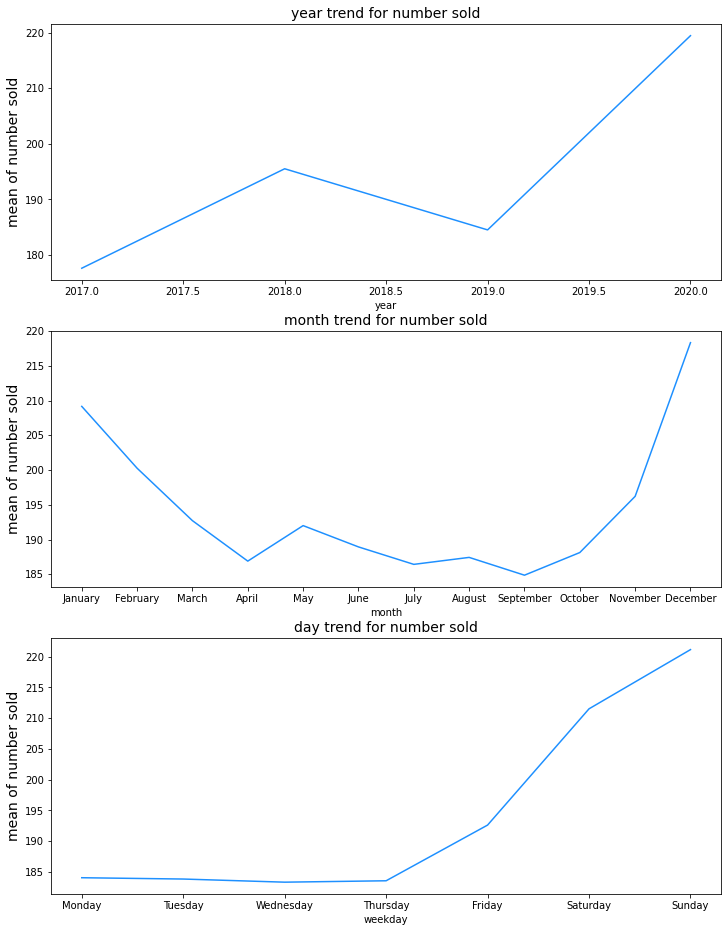

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 16))
sns.lineplot(x=sld_year.year, y=sld_year.num_sold ,ax=ax[0], color='dodgerblue')
ax[0].set_title('year trend for number sold', fontsize=14)
ax[0].set_ylabel(ylabel='mean of number sold', fontsize=14)

sns.lineplot(x="month", y=sld_month.num_sold,data= sld_month , ax=ax[1], color='dodgerblue')
ax[1].set_title('month trend for number sold', fontsize=14)
ax[1].set_ylabel(ylabel='mean of number sold', fontsize=14)

sns.lineplot(x="weekday", y=sld_day.num_sold, data = sld_day , ax=ax[2], color='dodgerblue')
ax[2].set_title('day trend for number sold', fontsize=14)
ax[2].set_ylabel(ylabel='mean of number sold', fontsize=14)

plt.show()

In [40]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [41]:
product_weights = train_df.groupby("product")["num_sold"].sum()/train_df["num_sold"].sum()
product_weights

product
Kaggle Advanced Techniques          0.287246
Kaggle Getting Started              0.230220
Kaggle Recipe Book                  0.172455
Kaggle for Kids: One Smart Goose    0.310079
Name: num_sold, dtype: float64

In [42]:
country_weights = train_df.groupby("country")["num_sold"].sum()/train_df["num_sold"].sum()
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: num_sold, dtype: float64

In [43]:
product_store_weights = train_df.groupby(["product","store"])["num_sold"].sum() / train_df.groupby(["product"])["num_sold"].sum()
product_store_weights

product                           store     
Kaggle Advanced Techniques        KaggleMart    0.742447
                                  KaggleRama    0.257553
Kaggle Getting Started            KaggleMart    0.742500
                                  KaggleRama    0.257500
Kaggle Recipe Book                KaggleMart    0.742765
                                  KaggleRama    0.257235
Kaggle for Kids: One Smart Goose  KaggleMart    0.742450
                                  KaggleRama    0.257550
Name: num_sold, dtype: float64

In [44]:
product_country_weights = train_df.groupby(["product","country"])["num_sold"].sum() / train_df.groupby(["product"])["num_sold"].sum()
product_country_weights

product                           country
Kaggle Advanced Techniques        Belgium    0.204103
                                  France     0.184540
                                  Germany    0.204512
                                  Italy      0.161737
                                  Poland     0.098189
                                  Spain      0.146919
Kaggle Getting Started            Belgium    0.204318
                                  France     0.184416
                                  Germany    0.204449
                                  Italy      0.161510
                                  Poland     0.098241
                                  Spain      0.147065
Kaggle Recipe Book                Belgium    0.204345
                                  France     0.184254
                                  Germany    0.204719
                                  Italy      0.161383
                                  Poland     0.098151
                                  Spain 

In [45]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Kaggle Advanced Techniques,4267
1,2017-01-01,Kaggle Getting Started,3492
2,2017-01-01,Kaggle Recipe Book,2900
3,2017-01-01,Kaggle for Kids: One Smart Goose,4693
4,2017-01-02,Kaggle Advanced Techniques,3242


In [46]:
print("unique product",train_df['product'].unique())
print("Unique countrry",train_df['country'].unique())
print("unique store",train_df['store'].unique())

unique product ['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']
Unique countrry ['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']
unique store ['KaggleMart' 'KaggleRama']


<AxesSubplot:>

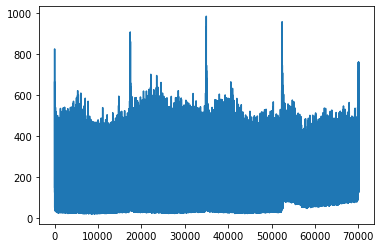

In [47]:
train_df['num_sold'].plot()

In [48]:
train_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,num_sold
0,0,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [49]:
test_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product
0,70128,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleRama,Kaggle Advanced Techniques


In [50]:
a= train_df.weekday.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
b= train_df['date'].dt.dayofweek
a,b
#train_df['dayofyear'] = train_df['date'].dt.dayofyear
#train_df['dayofmonth'] = train_df['date'].dt.days_in_month
c= np.arange(len(train_df.index)) # add a time step feature
#train['weekday'] = train['date'].dt.weekday

In [51]:
train_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,num_sold
0,0,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [52]:
a,b

(0        1
 1        1
 2        1
 3        1
 4        1
         ..
 70123    0
 70124    0
 70125    0
 70126    0
 70127    0
 Name: weekday, Length: 70128, dtype: int64,
 0        6
 1        6
 2        6
 3        6
 4        6
         ..
 70123    3
 70124    3
 70125    3
 70126    3
 70127    3
 Name: date, Length: 70128, dtype: int64)

In [53]:
train_df["is_weekend"]= train_df.day.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['Time_step'] = np.arange(len(train_df.index))

test_df["is_weekend"]= test_df.day.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['Time_step'] = np.arange(len(test_df.index))

In [54]:
train_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,0,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663,0,6,0
1,1,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615,0,6,1
2,2,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480,0,6,2
3,3,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,0,6,3
4,4,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240,0,6,4


In [55]:
train_data=train_df.drop(['row_id','weekday'],axis=1)
test_data=test_df.drop(['row_id','weekday'],axis=1)

In [56]:
train_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,0,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663,0,6,0
1,1,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615,0,6,1
2,2,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480,0,6,2
3,3,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,0,6,3
4,4,2017-01-01,1,Sunday,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240,0,6,4


In [57]:
test_df.head()

,row_id,date,day,weekday,month,quater,year,country,store,product,is_weekend,dayofweek,Time_step
0,70128,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Advanced Techniques,0,4,0
1,70129,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Getting Started,0,4,1
2,70130,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle Recipe Book,0,4,2
3,70131,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,0,4,3
4,70132,2021-01-01,1,Friday,January,1,2021,Belgium,KaggleRama,Kaggle Advanced Techniques,0,4,4


In [58]:
train_data.head()

,date,day,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,2017-01-01,1,January,1,2017,Belgium,KaggleMart,Kaggle Advanced Techniques,663,0,6,0
1,2017-01-01,1,January,1,2017,Belgium,KaggleMart,Kaggle Getting Started,615,0,6,1
2,2017-01-01,1,January,1,2017,Belgium,KaggleMart,Kaggle Recipe Book,480,0,6,2
3,2017-01-01,1,January,1,2017,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,0,6,3
4,2017-01-01,1,January,1,2017,Belgium,KaggleRama,Kaggle Advanced Techniques,240,0,6,4


In [59]:
a = np.sin((train_data.dayofweek-1)*(2.*np.pi/12))
b = np.cos((train_data.dayofweek-1)*(2.*np.pi/12))

In [60]:
le = LabelEncoder()
cols = [ "country","product","store","month" ,"year"]
for col in cols :
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

In [61]:
train_data.head()

,date,day,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,2017-01-01,1,4,1,0,0,0,0,663,0,6,0
1,2017-01-01,1,4,1,0,0,0,1,615,0,6,1
2,2017-01-01,1,4,1,0,0,0,2,480,0,6,2
3,2017-01-01,1,4,1,0,0,0,3,710,0,6,3
4,2017-01-01,1,4,1,0,0,1,0,240,0,6,4


In [62]:
train_data1=train_data.copy()
test_data1=test_data.copy()

In [63]:
train_data1.head()

,date,day,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,2017-01-01,1,4,1,0,0,0,0,663,0,6,0
1,2017-01-01,1,4,1,0,0,0,1,615,0,6,1
2,2017-01-01,1,4,1,0,0,0,2,480,0,6,2
3,2017-01-01,1,4,1,0,0,0,3,710,0,6,3
4,2017-01-01,1,4,1,0,0,1,0,240,0,6,4


In [64]:
train_data['month_sin'] = np.sin(2 * np.pi * train_data['month'] / max(train_data['month']))
train_data['month_cos'] = np.cos(2 * np.pi * train_data['month'] / max(train_data['month']))
train_data['dayofweek_sin'] = np.sin(2 * np.pi * train_data['dayofweek'] / max(train_data['dayofweek']))
train_data['dayofweek_cos'] = np.cos(2 * np.pi * train_data['dayofweek'] / max(train_data['dayofweek']))

train_data['quater_sin'] = np.sin(2 * np.pi * train_data['quater'] / max(train_data['quater']))
train_data['quater_cos'] = np.cos(2 * np.pi * train_data['quater'] / max(train_data['quater']))

In [65]:
test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / max(test_data['month']))
test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / max(test_data['month']))
test_data['dayofweek_sin'] = np.sin(2 * np.pi * test_data['dayofweek'] / max(test_data['dayofweek']))
test_data['dayofweek_cos'] = np.cos(2 * np.pi * test_data['dayofweek'] / max(test_data['dayofweek']))

test_data['quater_sin'] = np.sin(2 * np.pi * test_data['quater'] / max(test_data['quater']))
test_data['quater_cos'] = np.cos(2 * np.pi * test_data['quater'] / max(test_data['quater']))

In [66]:
train_data.head()

,date,day,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,2017-01-01,1,4,1,0,0,0,0,663,0,6,0,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
1,2017-01-01,1,4,1,0,0,0,1,615,0,6,1,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
2,2017-01-01,1,4,1,0,0,0,2,480,0,6,2,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
3,2017-01-01,1,4,1,0,0,0,3,710,0,6,3,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
4,2017-01-01,1,4,1,0,0,1,0,240,0,6,4,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17


In [67]:
train_data1.head()

,date,day,month,quater,year,country,store,product,num_sold,is_weekend,dayofweek,Time_step
0,2017-01-01,1,4,1,0,0,0,0,663,0,6,0
1,2017-01-01,1,4,1,0,0,0,1,615,0,6,1
2,2017-01-01,1,4,1,0,0,0,2,480,0,6,2
3,2017-01-01,1,4,1,0,0,0,3,710,0,6,3
4,2017-01-01,1,4,1,0,0,1,0,240,0,6,4


In [68]:
train_data.drop(['day','month','dayofweek'],axis=1,inplace=True)
test_data.drop(['day','month','dayofweek'],axis=1,inplace=True)

In [69]:
train_data.head()

,date,quater,year,country,store,product,num_sold,is_weekend,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,2017-01-01,1,0,0,0,0,663,0,0,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
1,2017-01-01,1,0,0,0,1,615,0,1,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
2,2017-01-01,1,0,0,0,2,480,0,2,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
3,2017-01-01,1,0,0,0,3,710,0,3,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
4,2017-01-01,1,0,0,1,0,240,0,4,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17


In [93]:
X_train = train_data[train_data.date.between('2017-01-01', '2020-10-31')].copy()
X_val = train_data[train_data.date.between('2017-11-01', '2020-12-31')].copy()
# X_train1 = train_data1[train_data1.date.between('2017-01-01', '2020-10-31')].copy()
# X_val1 = train_data1[train_data1.date.between('2020-11-01', '2020-12-31')].copy()

In [94]:
X_train.drop(['date'],axis=1,inplace=True)
X_val.drop(['date'],axis=1,inplace=True)
# X_train1.drop(['date'],axis=1,inplace=True)
# X_val1.drop(['date'],axis=1,inplace=True)

In [91]:
X_train

,quater,year,country,store,product,num_sold,is_weekend,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,1,0,0,0,0,663,0,0,0.755750,-0.654861,-2.449294e-16,1.0,1.000000e+00,6.123234e-17
1,1,0,0,0,1,615,0,1,0.755750,-0.654861,-2.449294e-16,1.0,1.000000e+00,6.123234e-17
2,1,0,0,0,2,480,0,2,0.755750,-0.654861,-2.449294e-16,1.0,1.000000e+00,6.123234e-17
3,1,0,0,0,3,710,0,3,0.755750,-0.654861,-2.449294e-16,1.0,1.000000e+00,6.123234e-17
4,1,0,0,1,0,240,0,4,0.755750,-0.654861,-2.449294e-16,1.0,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67195,4,3,5,0,3,485,0,67195,-0.540641,0.841254,-8.660254e-01,0.5,-2.449294e-16,1.000000e+00
67196,4,3,5,1,0,115,0,67196,-0.540641,0.841254,-8.660254e-01,0.5,-2.449294e-16,1.000000e+00
67197,4,3,5,1,1,139,0,67197,-0.540641,0.841254,-8.660254e-01,0.5,-2.449294e-16,1.000000e+00
67198,4,3,5,1,2,98,0,67198,-0.540641,0.841254,-8.660254e-01,0.5,-2.449294e-16,1.000000e+00


In [95]:
y_train=X_train["num_sold"]
X_train = X_train.drop("num_sold",axis=1)
y_val= X_val["num_sold"]
X_val= X_val.drop("num_sold",axis=1)


In [96]:
X_train.head()

,quater,year,country,store,product,is_weekend,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,1,0,0,0,0,0,0,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
1,1,0,0,0,1,0,1,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
2,1,0,0,0,2,0,2,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
3,1,0,0,0,3,0,3,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
4,1,0,0,1,0,0,4,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17


In [97]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500)

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=200)

In [101]:
from xgboost import XGBRegressor

class CustomXGBRegressor(XGBRegressor):
    
    def __init__(self, **params):
        
        super().__init__(**params)
        self.eval_set = params['eval_set']
    
    def fit(self, X, y):
        super().fit(X, y, eval_set=self.eval_set, verbose=100) # output progress every 100 iterations

In [102]:
xgb = CustomXGBRegressor(n_estimators = 1000, early_stopping_rounds = 20, learning_rate = 0.05, eval_set = [(X_val, y_val)])

In [103]:
from sklearn.ensemble import VotingRegressor

model = VotingRegressor(estimators=[
    ('xgb', xgb), ('rf', rf), ('gb', gb)])

model.fit(X_train,y_train)

[12:09:57] WARNING: ../src/learner.cc:627: 
Parameters: { "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:225.68437
[100]	validation_0-rmse:23.77260
[200]	validation_0-rmse:19.81771
[300]	validation_0-rmse:18.63653
[400]	validation_0-rmse:18.04360
[500]	validation_0-rmse:17.54480
[600]	validation_0-rmse:17.30441
[700]	validation_0-rmse:17.07961
[800]	validation_0-rmse:16.92248
[900]	validation_0-rmse:16.80866
[999]	validation_0-rmse:16.65344


VotingRegressor(estimators=[('xgb',
                             CustomXGBRegressor(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=20,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                eval_set=[(       quater  year  country  store  product  is_weekend  Time_step  \
14592       4     0        0      0        0           0      14592   
14593       4     0        0      0        1           0      14593   
14594       4     0        0      0        2           0      14594   
14595       4     0        0      0        3...
  

In [105]:
from sklearn.metrics import mean_squared_error
val_pred= model.predict(X_val)

errors = mean_squared_error(val_pred,y_val)
# report error
print(errors)

332.2429646262352


In [109]:
test_data.drop('date',axis=1,inplace=True)

In [111]:
X_train.head()

,quater,year,country,store,product,is_weekend,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,1,0,0,0,0,0,0,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
1,1,0,0,0,1,0,1,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
2,1,0,0,0,2,0,2,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
3,1,0,0,0,3,0,3,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17
4,1,0,0,1,0,0,4,0.75575,-0.654861,-2.449294e-16,1.0,1.0,6.123234e-17


In [110]:
test_data.head()

,quater,year,country,store,product,is_weekend,Time_step,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quater_sin,quater_cos
0,1,0,0,0,0,0,0,0.75575,-0.654861,-0.866025,-0.5,1.0,6.123234e-17
1,1,0,0,0,1,0,1,0.75575,-0.654861,-0.866025,-0.5,1.0,6.123234e-17
2,1,0,0,0,2,0,2,0.75575,-0.654861,-0.866025,-0.5,1.0,6.123234e-17
3,1,0,0,0,3,0,3,0.75575,-0.654861,-0.866025,-0.5,1.0,6.123234e-17
4,1,0,0,1,0,0,4,0.75575,-0.654861,-0.866025,-0.5,1.0,6.123234e-17


In [112]:
preds = model.predict(test_data)

In [113]:
preds[:5]

array([534.67103283, 522.06698284, 404.68381579, 568.48012747,
       189.46716659])

In [115]:
submission = pd.DataFrame({
    'row_id' : test_df['row_id'],
    'num_sold' : preds
})

In [117]:
submission.head()

,row_id,num_sold
0,70128,534.671033
1,70129,522.066983
2,70130,404.683816
3,70131,568.480127
4,70132,189.467167


In [118]:
submission.to_csv('submission.csv', index= False)